In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" #"all"

### Inverted Pendulum Swingup problem
https://gymnasium.farama.org/environments/classic_control/pendulum/ 

Observation space: 
- cos(theta), 
- sin(theta)  theta is the pendulum’s angle normalized between [-pi, pi]  , 
- angular velocity in range(-8,8) 

Action space: torque applied to free end +ve counter clockwise \
Goal: swing to upright position  (theta = 0 , x=1 y=0) - x and y on opposite axes - check diagram \ 
objective is to maintain the pendulum in the upright position \
Reward: $r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)$ \

The starting state is a random angle in [-pi, pi] and a random angular velocity in [-1,1]. \
The episode truncates at 200 time steps.

- 0 to 180 = [0,pi] and  180-360 [-pi,0]

https://gammamodels.github.io/ 
- reward and value estimates diagram #TODO https://github.com/jannerm/gamma-models/blob/main/scripts/gamma-pendulum.ipynb

### Load all

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import model_viz_functions_pendulum as modelviz_pendulum_utils
import model_viz_loaders as modelviz_loaders
# from model_viz_functions_riab import plot_samples 

import os
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

# import copy

2024-09-20 03:35:25.674113: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 03:35:25.674160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 03:35:25.674208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 03:35:26.708233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[03:35:27] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=410147;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=565379;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=342954;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=279063;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

[03:35:28] INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=642045;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=583671;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/sruthi/Documents/thesis/distributional-sr/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, se

### ENV and MODEL path and dataset

In [3]:
# env
ENVIRONMENT = "Pendulum-v1" 
model_path = "logdir_pendulum_200k" 
# model_path = "logdir-500k_pendulum" 

In [4]:
# import pathlib 
# import pickle 
# dataset_path = pathlib.Path("datasets/pendulum_test/sac/dataset.pkl")
# with open(dataset_path, "rb") as f:
#     dataset1 = pickle.load(f)

# folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)

print("Dataset observations shape: ",dataset.observation.shape)

Dataset observations shape:  (500001, 3)


In [5]:
env = envs.make(ENVIRONMENT)  #config.env
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

### Model stuff - restoring checkpoint

In [6]:
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=963092;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=632535;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=236936;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=860781;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=816587;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=172840;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[03:35:35] INFO     Restoring item from                                                         ]8;id=134171;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=769365;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir_pendulum_200k/500000                    
                    .                                                                                              

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=511668;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=134776;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir_pendulum_200k/500000                    
                    .                                                                                              

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 8, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 3), 'kernel': (10, 32, 3)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 3
)>


In [7]:
num_samples= 32 #config.plot_num_samples # Number of state samples the model should generate
num_outer=config.num_outer # Number of model atoms   
num_latent_dims= config.latent_dims # Dimension of input noise 
print('observation_spec shape:', env.observation_spec().shape[0], ' num_latent_dims ',num_latent_dims)
print(f'DSM model input (n_samples {num_samples}, n_atoms {num_outer}, atom_input {num_latent_dims+env.observation_spec().shape[0]}) ')

observation_spec shape: 3  num_latent_dims  5
DSM model input (n_samples 32, n_atoms 10, atom_input 8) 


### Source states

In [8]:
# from dsm import plotting
# saved_source_states = plotting.source_states(config.env) 
# # has 2 lists of 9 elements each - each element is a list of 2 elements  - states:[theta, thetadot] observations: [sin(theta), cos(theta), thetadot]
# # print('polar coords, angular velocity',saved_source_states[0]) 
# # print('cartesian coords, angular velocity',saved_source_states[1])
# sources_all = saved_source_states[1]

In [9]:
def get_states(n_steps, theta_range=[0,2*np.pi], thetadot_range=[-8,8]):
    """
        for # inputs from pi/2 to 3pi/2  - below the pendulum bar: get_states(50, theta_range = [np.pi/2, 3*np.pi/2],thetadot_range=[-4,4])
        returns `n_steps`^2 states from pendulum environment,
        sampling angle and angular velocity uniformly within environment bounds
    """
    theta_range = np.linspace(*theta_range, n_steps)
    thetadot_range = np.linspace(*thetadot_range, n_steps)[::-1]

    states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for thetadot in thetadot_range
        for theta in theta_range
    ])

    return states, theta_range, thetadot_range

def get_condition_states():
    """
        returns a few representative conditioning states
    """
    thetas = [np.pi/2, np.pi, np.pi*3/2]
    thetadots = [-4, 0, 4]

    condition_states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for theta in thetas
        for thetadot in thetadots
    ])
    
    return condition_states, thetas, thetadots

# sources_all, *_ = get_states(50)
# sources_all.shape

In [10]:
sources_test, *_ = get_condition_states()

In [11]:
# from dsm import rewards
# # for reward_fn_name, reward_fn in getattr(rewards, config.env).items():
# from dsm.plotting import utils as plot_utils
# reward_fn_name = 'Default'
# reward_fn = getattr(rewards, config.env)[reward_fn_name]
# reward_fn
def _angle_normalize(x: jax.Array) -> jax.Array:
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi
def pendulum_no_action_penalty(states, a=None) -> jax.Array:
    del a
    if len(states) == 3:
        t = jnp.arctan2(states[1], states[0]) # angle to the vertical arctan2(sin_theta, cos_theta)
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif len(states)==2:
        t = states[0]
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif states.shape[1] == 3:
        cos_theta = states[:,0]
        sin_theta = states[:,1]
        thetadot = states[:,2]

        theta = np.arctan2(sin_theta, cos_theta)
        costs = _angle_normalize(theta)**2 + .1*thetadot**2 #+ .001*(u**2)

        return -costs

reward_fn = pendulum_no_action_penalty 

# plt.rcParams['figure.figsize'] = [2, 3]
# n_steps = 41
# queries, theta_range, thetadot_range = get_states(n_steps)
# rewards = reward_fn(queries)

# rewards_2d = rewards.reshape(n_steps, n_steps)
# plt.imshow(rewards_2d, aspect='auto', cmap='inferno')
# # plt.gca().invert_yaxis()
# plt.xticks([])
# plt.yticks([])
# plt.colorbar()
# # plt.tight_layout()
# # scatter = plt.contourf(theta_range, thetadot_range, rewards_2d, cmap='inferno')

### compute DSM samples

atom_input = latent+source_state <br>
DSM model input (n_samples, n_atoms, atom_input)

In [12]:
source_idx = 0
source_state_current = sources_test[source_idx]
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, 
        source_state_current=source_state_current, num_samples = 32
    )

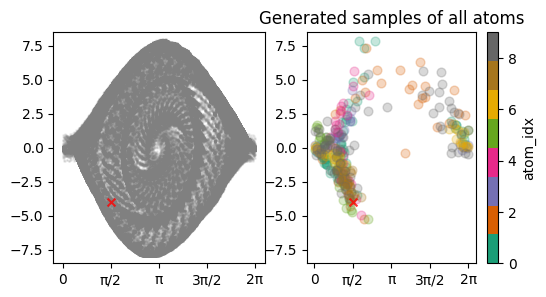

In [13]:
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=True, atom='all')

# img_dict = plotting.plot_samples(state.generator, jax.random.PRNGKey(0),config=config)
# src_idx = 0
# plot_key = list(img_dict.keys())[src_idx]
# sample_plotarray = img_dict[plot_key]
# plt.imshow(sample_plotarray)

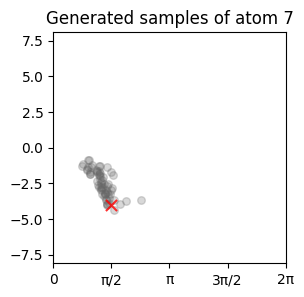

In [14]:
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source_state_current, num_samples = 64
    )
atom_idx = 7
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 


#### Exploring actions and rewards of the 10 atoms for the samples above from  one source state

DEBUG POLICY  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x75c84c7a3310>


[03:35:39] INFO     Converting library function __inference_converted_fun_tf_30                       ]8;id=79680;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py\tf2jax.py]8;;\:]8;id=427084;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py#986\986]8;;\

DEBUG pure_policy_func  <tf2jax._src.tf2jax.AnnotatedFunction object at 0x75c82c77cd00> policy_params  {}


/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:
/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:


debug actions min max -1.0 0.9999263


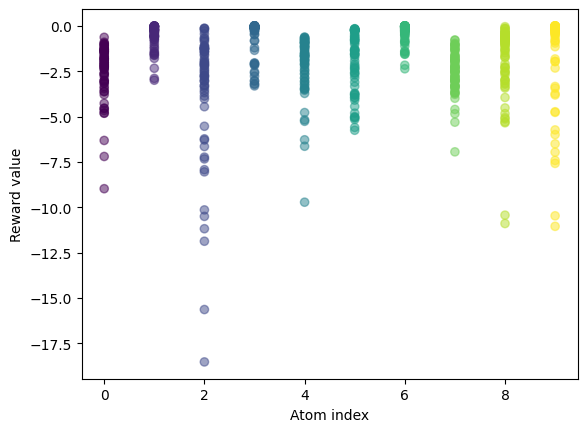

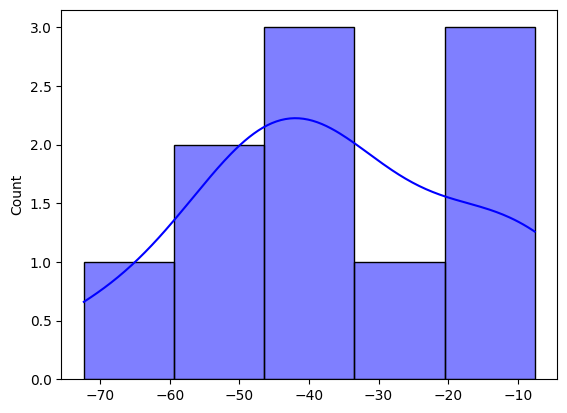

In [15]:
# Exploring actions and rewards of the 10 atoms for the samples above from  one source state

# plotting utils
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
atom_idx_values = np.arange(samples.shape[0])
norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))
sm = ScalarMappable(cmap='tab10', norm=norm)

policy = datasets.make_policy(config.env)
def apply_policy_to_batch(batch):
    keys,samples = batch
    return jax.lax.map(lambda x: policy(x[0],x[1]),(keys,samples))
keys = jax.random.split(jax.random.PRNGKey(0), np.prod(samples.shape[:-1]))
keys = jnp.array(keys).reshape(*samples.shape[:-1], -1)
actions = jax.lax.map(apply_policy_to_batch, (keys,samples))[1]
print('debug actions min max',np.min(actions), np.max(actions))

# # Assuming actions[1] has shape (10, 64, 1, 1)
# # Reshape it to (10, 64)
# reshaped_actions = actions.reshape(actions.shape[0], -1)
# # for i in range(10):
# #     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
# x_coords = np.repeat(np.arange(reshaped_actions.shape[0]), reshaped_actions.shape[1])
# # Flatten reshaped_actions) for plotting
# flat_actions = reshaped_actions.flatten()
# plt.scatter(x_coords, flat_actions, c=x_coords, alpha=0.5, cmap='viridis')
# plt.xlabel('Atom index')
# plt.ylabel('Action value')
# plt.show()

rewards = jax.vmap(jax.vmap(reward_fn))(samples, actions).squeeze()

reshaped_rewards = rewards.reshape(rewards.shape[0], -1)
# for i in range(10):
#     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
x_coords = np.repeat(np.arange(reshaped_rewards.shape[0]), reshaped_rewards.shape[1])
# Flatten reshaped_actions) for plotting
flat_rewards = reshaped_rewards.flatten()
plt.scatter(x_coords, flat_rewards, c=x_coords, alpha=0.5, cmap='viridis')
plt.xlabel('Atom index')
plt.ylabel('Reward value')
plt.show()

reward_mean = rewards.mean(axis=-1) / (1.0 - config.gamma)  
reward_mean.shape
import seaborn as sns
sns.histplot(reward_mean, kde=True, color='blue')

## Experiments

#### ALL SOURCES _ PREDICTIONs

DSM model input (n_samples, n_atoms, state_dims + latent_dims)
To generate 1 sample , 1 atom's input = state_dims + random_latent_dims
1. All atoms - All source states - Two different latents (potentially unlimited number of latents) 
2. 1 source state - all atoms - 50 different latents?

- predictions may be in one manifold for each atom??

In [16]:
sources_all, theta_all, thetadot_all = get_states(20) #get_condition_states()

In [ ]:
# sources_all1, theta_all1, thetadot_all1 = get_states(5) #get_condition_states()
# # All atoms - For the same source state - Two different latents (potentially unlimited number of latents) 
# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
# thetas = np.arctan2(sources_all1[:, 1], sources_all1[:, 0]) % (2 * np.pi)
# velocities = sources_all1[:, -1]
# colors = range(len(thetas))  # Create a list of numbers from 0 to len(xs)-1
# reversed_map = plt.cm.get_cmap('viridis') .reversed() 
# scatter = axs.scatter(thetas, velocities, alpha=0.3, c=colors, cmap=reversed_map)  # Use the numbers as colors
# axs.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
# axs.set_xlabel('θ')
# axs.set_ylabel('θdot')
# fig.suptitle('Source states')
# sources_all.shape
# latent_rng_seed = 0
# modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all1, atoms_sel = 'all',
#                               title='each atom predictions over source state: latent_rng_seed 0')
# latent_rng_seed = 2
# modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all1, atoms_sel = 'all',
#                               title='each atom predictions over source state: latent_rng_seed 2')

In [ ]:
# All atoms - For the same source state - Two different latents (potentially unlimited number of latents) 
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
thetas = np.arctan2(sources_all[:, 1], sources_all[:, 0]) % (2 * np.pi)
velocities = sources_all[:, -1]
colors = range(len(thetas))  # Create a list of numbers from 0 to len(xs)-1
reversed_map = plt.cm.get_cmap('viridis') # .reversed() 
scatter = axs.scatter(thetas, velocities, alpha=0.3, c=colors, cmap=reversed_map)  # Use the numbers as colors
axs.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
axs.set_xlabel('θ')
axs.set_ylabel('θdot')
fig.suptitle('Source states')
sources_all.shape
latent_rng_seed = 0
modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
                              title='each atom predictions over source state: latent_rng_seed 0')
latent_rng_seed = 2
modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
                              title='each atom predictions over source state: latent_rng_seed 2')

In [19]:
#TODO ASK 1 atom - 1 source - 10 latent values - gives 10 ratemaps - how to quantify

### Dense 3 activations  - output ratemaps over cos(theta) , sin(theta), angular velocity

In [20]:
# All atoms - return specified layer activation - Plot rate map of neuron_idx
def explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed):
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
    activations_layer_all_atoms = [] 
    for atom_num in range(config.num_outer):
        atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
        activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator, atom_params, sources_all,zs, layers)
        # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
        activations_layer_all_atoms.append(activations_layer) 
    return activations_layer_all_atoms

In [21]:
import importlib 
importlib.reload(modelviz_pendulum_utils)

In [22]:
sources_all, theta_all, thetadot_all = get_states(10) #get_condition_states()

Layer: ['Dense_3'] - Neuron: 2- Angular Velocity


/home/sruthi/Documents/thesis/distributional-sr/model_viz_functions_pendulum.py:227: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


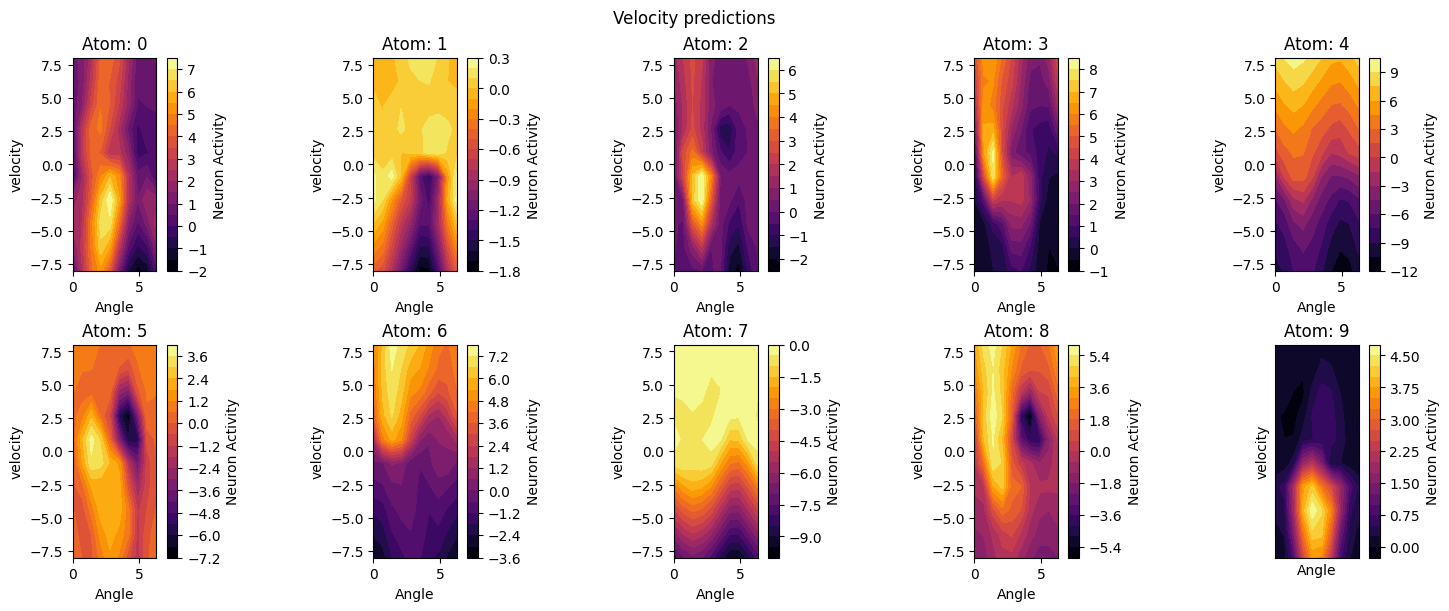

In [23]:
# All atoms - activation of neuron predicting angular velocity - plot rate map
layers = ['Dense_3',]
latent_rng_seed = 0 
neuron_idx=2 # angular velocity (ONE LATENT)
print(f'Layer: {layers} - Neuron: {neuron_idx}- Angular Velocity')
activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed)
modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', 
                                                                      neuron_idx, theta_all, thetadot_all, normalize=False,title='Velocity predictions')

# #TODO how to quantify angular velocity wrt different latents
# latent_rng_seed = 3 
# neuron_idx=2 # angular velocity (ONE LATENT)
# activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed)
# modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, theta_all, thetadot_all)

In [24]:
activations_layer_all_atoms

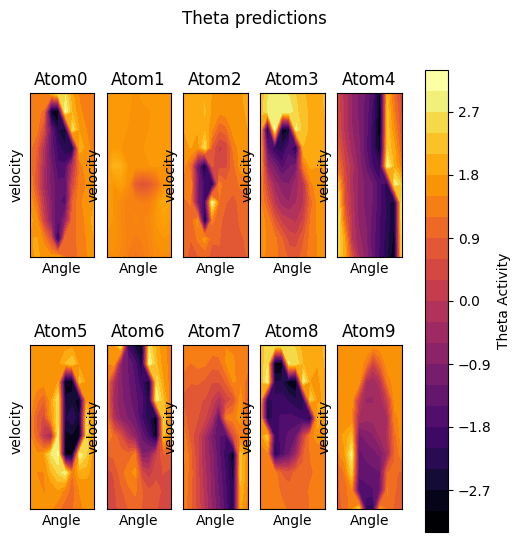

In [25]:
# Plot with respect to theta arctan(neuron1 output, neuron2 output)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
n = len(activations_layer_all_atoms)
cols = 5 
rows = n // cols 
position = range(1,n + 1)
fig = plt.figure(figsize=(6,6))

# Find global min and max
global_min = -np.pi
global_max = np.pi
# global_min = np.min([np.min(activations_layer) for activations_layer in activations_layer_all_atoms])
# global_max = np.max([np.max(activations_layer) for activations_layer in activations_layer_all_atoms])
scatters = []
for k, activations_layer in enumerate(activations_layer_all_atoms): 
    ax = fig.add_subplot(rows, cols, position[k])
    ax.set_aspect('equal')
    label = f'Atom: {k}'
    theta = np.arctan2(activations_layer[:, 0], activations_layer[:, 1])
    activations_2d = theta.reshape(len(thetadot_all), len(theta_all))
    scatter = ax.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
    scatters.append(scatter)
    ax.set_aspect('equal')
    ax.set_title(f'Atom{k}')
    plt.xticks([]), plt.yticks([]) 
    ax.set_xlabel('Angle')
    ax.set_ylabel('velocity')

# Create colorbar as a common for all subplots.
fig.colorbar(scatters[0], ax=fig.get_axes(), label='Theta Activity')
fig.suptitle('Theta predictions')
plt.show()

### 1 atom

To generate 1 sample , 1 atom's input = state_dims + random_latent_dims

- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

In [26]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 7  # ith atom
num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

# All intermediate layers
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
latent_rng_seed = 0
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)

for keys,values in zip(atom_activations_alllayers.keys(), atom_activations_alllayers.values()):
    print(keys, values.shape)

# import joblib
# joblib.dump(atom_activations_alllayers, model_path+f'/activations_alllayers_atom{atom_i}_latent{latent_rng_seed}.pkl')

# layers = ['Dense_3',]
# latent_rng_seed = 0
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all, zs, layers)

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (8, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (3,), 'kernel': (32, 3)}}
Dense_0 (100, 32)
Dense_1 (100, 32)
Dense_2 (100, 32)
Dense_3 (100, 3)


In [27]:
importlib.reload(modelviz_pendulum_utils)

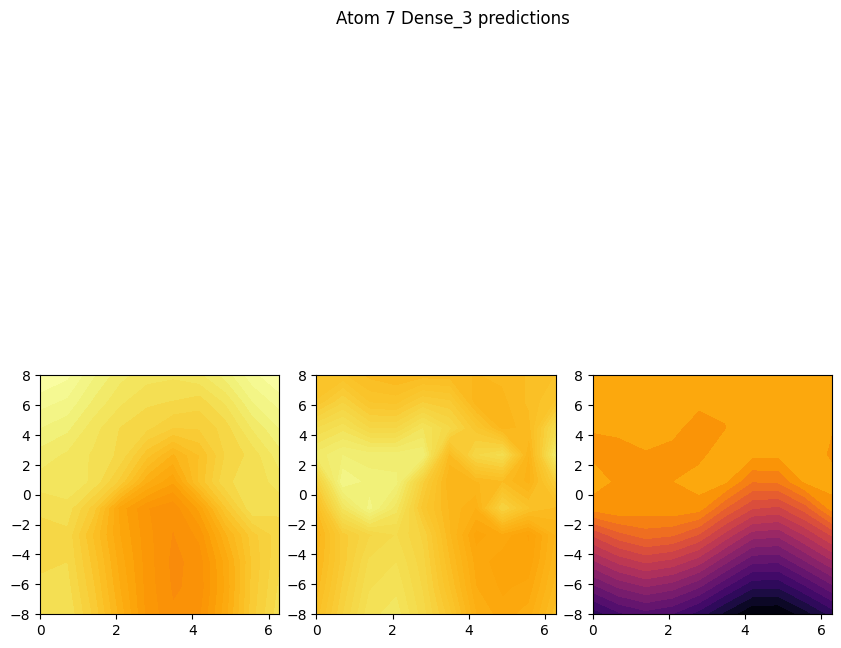

In [28]:
modelviz_pendulum_utils.plot_neuron_activations(activations_layer=atom_activations_alllayers['Dense_3'], 
                                                neuron_idx = 'all', 
                                                figlabel=f'Atom {atom_i} Dense_3 predictions', 
                                                xpos=theta_all, ypos=thetadot_all, normalize=False)

### Entropy

analyze the entropy of neuron activations with respect to specific input dimensions - theta and velocity  - get for each layer
- entropy over layers
- or entropy wrt source states? 


https://link.springer.com/chapter/10.1007/978-3-030-41117-6_3 - entropy reduces with layer depth? ; the neuron activation patterns become more and more stable with the depth of the fully connected layers
https://www-sciencedirect-com.libproxy.ucl.ac.uk/science/article/pii/S1570870520306958


In [29]:
from scipy.stats import entropy

In [30]:
def compute_entropy_activations(activations, label=None, plot_normalized = False,normalize=True):
    # Apply to handle negative activations and normalize
    if normalize:
        normalized_activations = (activations - np.amin(activations)) / (np.amax(activations) - np.amin(activations)) #np.sum(activations, axis=1, keepdims=True)
        # print('debug',normalized_activations) 
    elif plot_normalized:
        plt.figure()
        plt.plot(normalized_activations, label=label)
    # entropy = -np.sum(normalized_activations * np.log(normalized_activations + 1e-9))/np.log(2)  # Adding a small value to prevent log(0)
    # return entropy #/normalized_activations.shape[0]
    activation_entropy =  entropy(normalized_activations, base=len(normalized_activations)) #TODO - ask standard practice of base
    return activation_entropy

Layer Dense_3 , Neuron_idx: 2, 
Entropy wrt velocity 0.9209790573735384 
Entropy wrt angles 0.8889974612313757


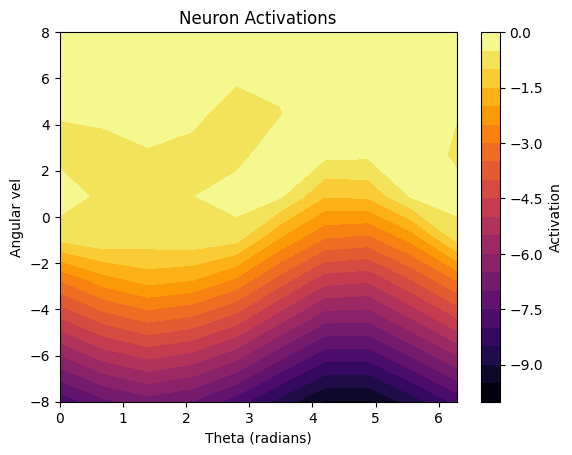

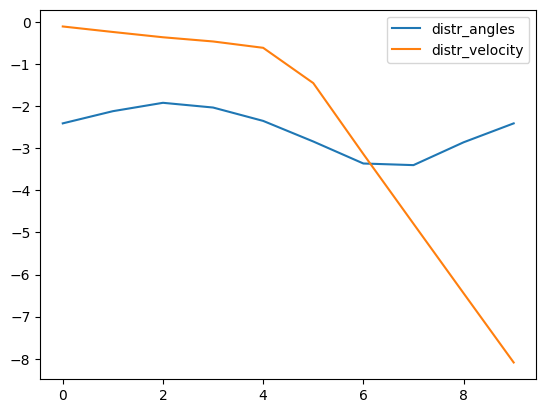

In [31]:
def compute_entropy_vel_angle_neuron(activations_all,layer, neuron_idx, plot=False, normalize=True):
    activations_selected = activations_all[layer][:, neuron_idx]
    activations_2d = activations_selected.reshape(len(thetadot_all), len(theta_all))
    distr_velocity = np.mean(activations_2d, axis=1)
    distr_angles = np.mean(activations_2d, axis=0)
    if plot:
        plt.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20)  # Theta vs Angular vel
        plt.colorbar(label='Activation')
        plt.xlabel('Theta (radians)')
        plt.ylabel('Angular vel')
        plt.title('Neuron Activations')
        plt.figure()
        plt.plot(distr_angles,label='distr_angles')
        plt.plot(distr_velocity,label='distr_velocity')
        plt.legend()
    entropy_vel = compute_entropy_activations(distr_velocity, normalize=normalize)
    entropy_angles = compute_entropy_activations(distr_angles, normalize=normalize)
    return entropy_vel, entropy_angles

layer = 'Dense_3' 
neuron_idx = 2
entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx,plot=1)
print(f'Layer {layer} , Neuron_idx: {neuron_idx}, \nEntropy wrt velocity',entropy_vel, '\nEntropy wrt angles',entropy_angles)

del entropy_vel, entropy_angles

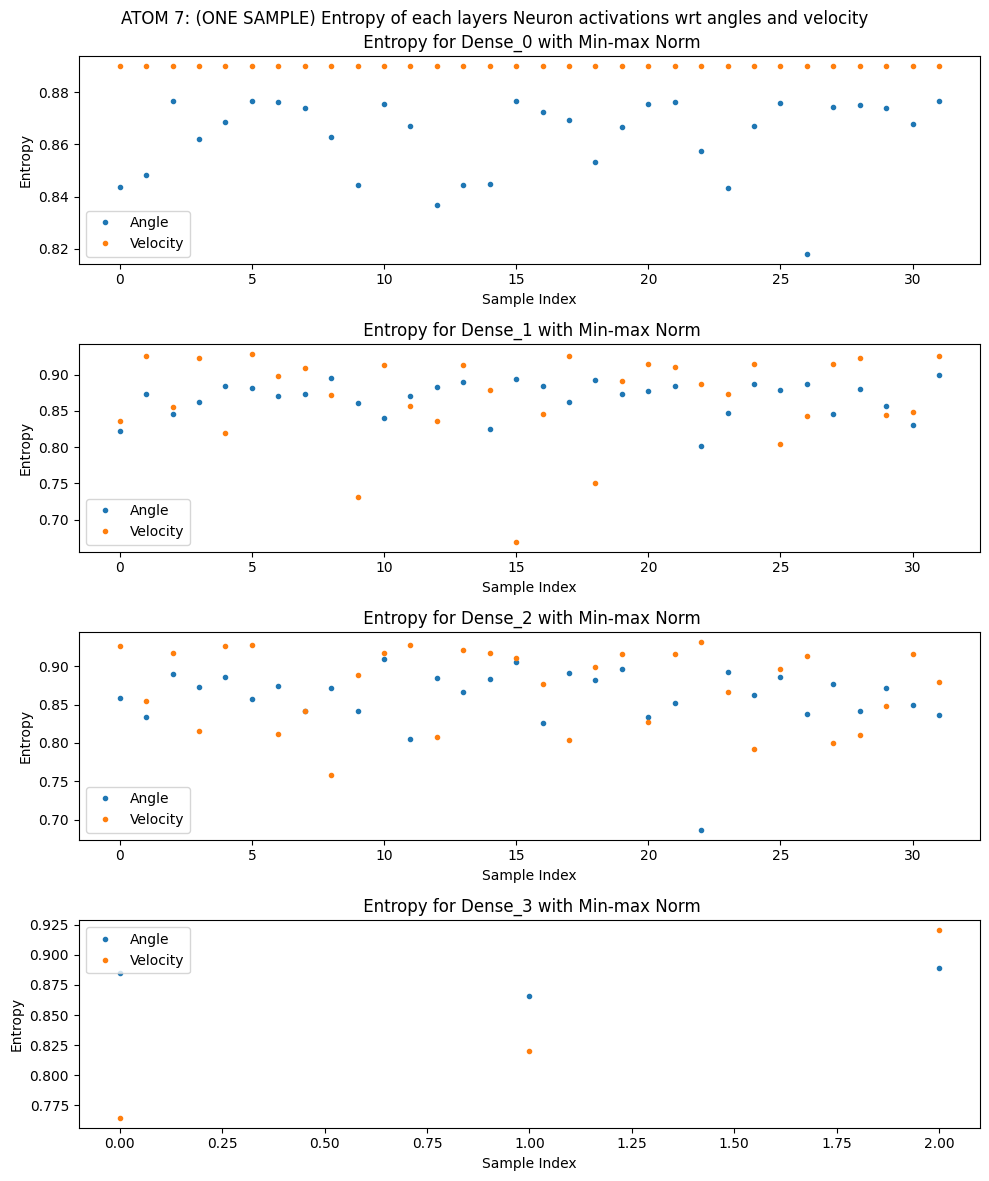

In [32]:
#TODO: ask - might depend on how we normalize - I did minmax not softmax , also - one latent
#TODO - do for multiple latents? all atoms?

def plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    n_layers = len(layer_names)
    fig, axs = plt.subplots(n_layers, 1, figsize=(10, n_layers * 3))
    if n_layers == 1:
        axs = np.array([axs])
    for i, layer in enumerate(layer_names):
        axs[i].plot(angle_entropy_all[layer],'.',label='Angle')
        axs[i].plot(vel_entropy_all[layer],'.',label='Velocity')
        axs[i].set_title(f' Entropy for {layer} with Min-max Norm')
        axs[i].set_xlabel('Sample Index')
        axs[i].set_ylabel('Entropy')
        axs[i].legend()

    fig.suptitle(f'ATOM {atom_i}: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity')
    plt.tight_layout()
    plt.show()

atom_i = 7  # ith atom
latent_rng_seed = 0
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers)

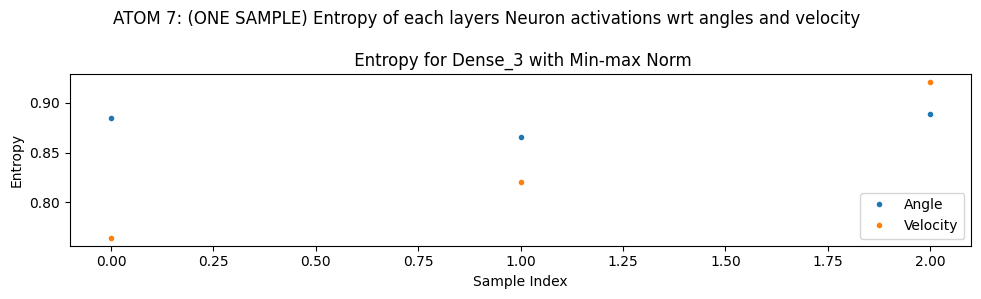

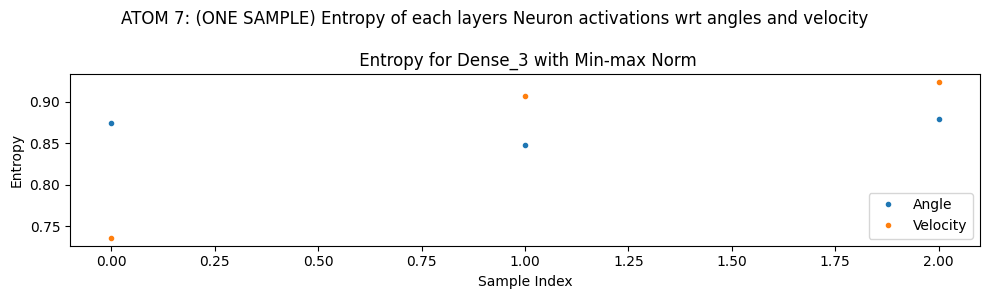

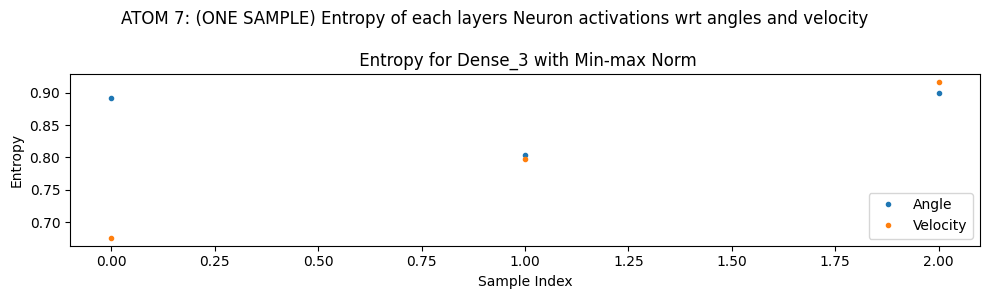

In [33]:
# check dense_3 - different latents
atom_i = 7  # ith atom
layers = ['Dense_3']
for latent_rng_seed in range(3):
    plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers)


In [34]:
def print_entropies_layers_1atom(atom_i, latent_rng_seed, layers):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    n_layers = len(layer_names)
    print(f'ATOM {atom_i}: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity')
    print((f' Entropy for {layer} with Min-max Norm'))
    for i, layer in enumerate(layer_names):
        print('Angle', angle_entropy_all[layer])
        print('Velocity', vel_entropy_all[layer])

In [35]:
# check dense_3 - different atoms - 1 latent
latent_rng_seed = 0  # ith atom
layers = ['Dense_3']
for atom_i in range(config.num_outer):
    print(f'ATOM {atom_i}')
    print_entropies_layers_1atom(atom_i, latent_rng_seed, layers)
    # plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers)

ATOM 0
ATOM 0: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity
 Entropy for Dense_3 with Min-max Norm
Angle [0.8776944049356178, 0.8899914824149311, 0.8403690648089218]
Velocity [0.7674826168405309, 0.8635327093861517, 0.8933160690984309]
ATOM 1
ATOM 1: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity
 Entropy for Dense_3 with Min-max Norm
Angle [0.8881328698894291, 0.7998874485647541, 0.8770497407805328]
Velocity [0.9203275593228164, 0.7930317569424837, 0.9163419485522524]
ATOM 2
ATOM 2: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity
 Entropy for Dense_3 with Min-max Norm
Angle [0.9206990747401702, 0.9240816459927107, 0.8182307634369167]
Velocity [0.8345954584344374, 0.871487053275934, 0.9222522328394755]
ATOM 3
ATOM 3: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity
 Entropy for Dense_3 with Min-max Norm
Angle [0.8683926446227513, 0.8304395179923162, 0.851831371

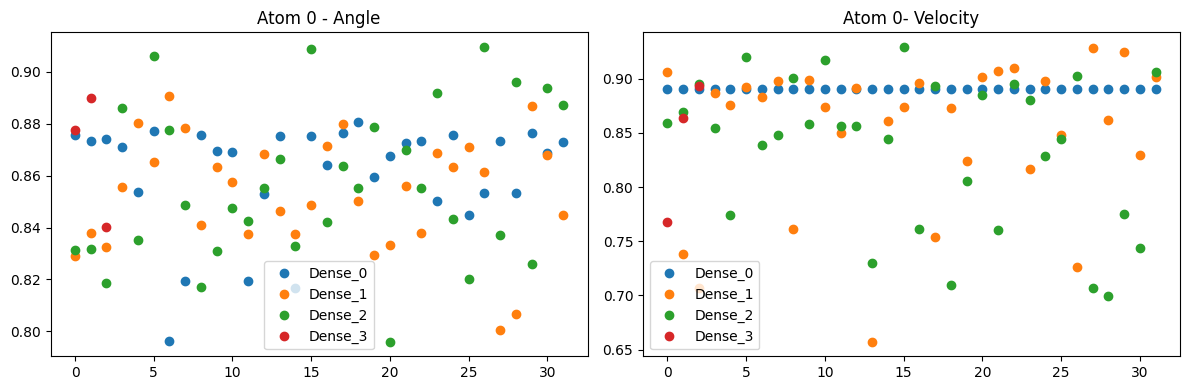

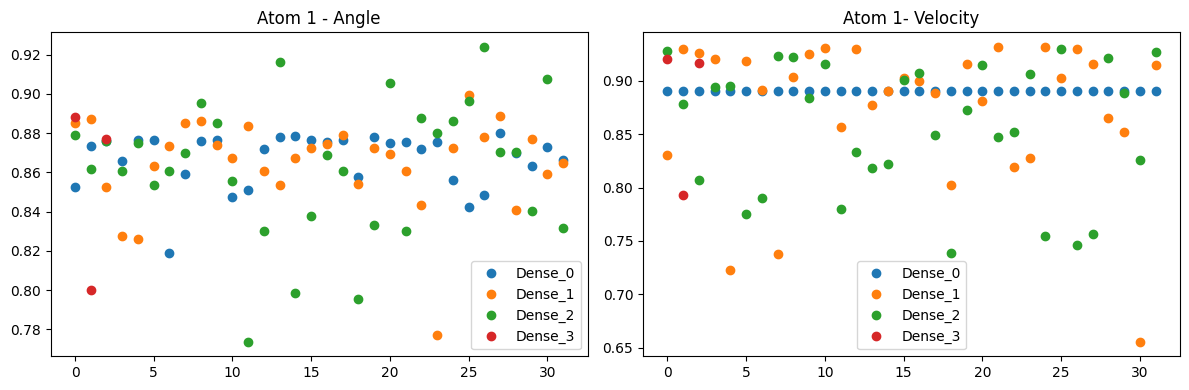

In [36]:
def choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    axs[0].set_title(f'Atom {atom_i} - Angle')
    for layer in layer_names:
        axs[0].plot(angle_entropy_all[layer],'o',label=f'{layer}')
    axs[0].legend()
    axs[1].set_title(f'Atom {atom_i}- Velocity')
    for layer in layer_names:
        axs[1].plot(vel_entropy_all[layer],'o',label=f'{layer}')
    axs[1].legend()
    plt.tight_layout()
    plt.show()
    # plt.figure(figsize=(6, 4))
    # plt.title(f'Atom {atom_i}')
    # for layer in layer_names:
    #     plt.plot(angle_entropy_all[layer],'o',label=f'{layer} - Angle')
    # plt.legend()
    # plt.figure(figsize=(6, 4))
    # plt.title(f'Atom {atom_i}')
    # for layer in layer_names:
    #     plt.plot(vel_entropy_all[layer],'o',label=f'{layer} - Velocity')
    # plt.legend()

latent_rng_seed = 0  # ith atom
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
for atom_i in range(2):
    choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers)

### Linear decoder

1. Train decoder to map neuron activations to source states 
2. Train decoder to map neuron activations to predicted state
- Single latent, different sources split as train and test

In [37]:
sources_all, theta_all, thetadot_all = get_states(30) 
sources_all.shape

In [38]:
# Training data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge   #Linear least squares with l2 regularization.
# from sklearn.gaussian_process import GaussianProcessRegressor

train_sources, test_sources = train_test_split(sources_all, test_size=0.2, random_state=42)
print(train_sources.shape)


(720, 3)


In [39]:
# get model's predictions for all sources
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# single_layer = 'Dense_2'
# layers = [single_layer]
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']

#### Decoder from layer activations to source

R2 score for layer Dense_0: 0.9999999986596455
R2 score for layer Dense_1: 0.9988968037770537
R2 score for layer Dense_2: 0.9970967625108207
R2 score for layer Dense_3: 0.6377275106200605


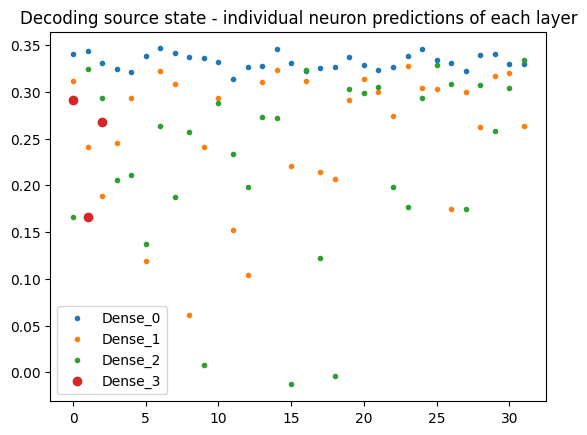

In [40]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_sources)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_sources)
    print(f'R2 score for layer {layer}: {layer_score}')

layer_names = list(train_activations_all.keys())
for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_sources)
        test_activations_neuron = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations_neuron,test_sources))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding source state - individual neuron predictions of each layer')

In [41]:
## Train with 1 latent  and Test with different latents - decoding source state 
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))

train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)


zs = jax.random.normal(jax.random.PRNGKey(20), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)

# PREDICTING SOURCE STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_sources)

    # Original latent - different source
    layer_score = round(model_LR.score(test_activations_all[layer],test_sources),3)
    print(f'--- Original latent - different source ::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = round(model_LR.score(train_activations_all_DIFF_LATENT[layer],train_sources),3)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = round(model_LR.score(test_activations_all_DIFF_LATENT[layer],test_sources),3)
    print(f'Different latent - different source ::: R2 score for layer {layer}: {layer_score}')

--- Original latent - different source ::: R2 score for layer Dense_0: 1.0
Different latent - same training source ::: R2 score for layer Dense_0: 0.935
Different latent - different source ::: R2 score for layer Dense_0: 0.933
--- Original latent - different source ::: R2 score for layer Dense_1: 0.999
Different latent - same training source ::: R2 score for layer Dense_1: 0.834
Different latent - different source ::: R2 score for layer Dense_1: 0.834
--- Original latent - different source ::: R2 score for layer Dense_2: 0.997
Different latent - same training source ::: R2 score for layer Dense_2: 0.909
Different latent - different source ::: R2 score for layer Dense_2: 0.911
--- Original latent - different source ::: R2 score for layer Dense_3: 0.638
Different latent - same training source ::: R2 score for layer Dense_3: 0.313
Different latent - different source ::: R2 score for layer Dense_3: 0.275


#### Decoder to end

R2 score for layer Dense_0: 0.7276816368103027
R2 score for layer Dense_1: 0.9559624195098877
R2 score for layer Dense_2: 0.975938618183136
R2 score for layer Dense_3: 0.9999999403953552


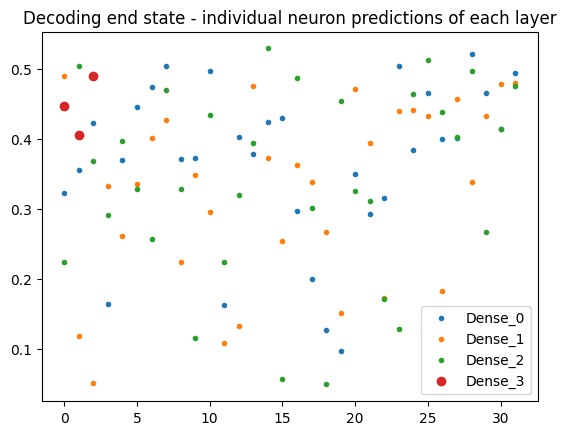

In [42]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_endstate)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_endstate)
    print(f'R2 score for layer {layer}: {layer_score}')
    # for neuron_idx in range(train_activations_all[layer].shape[1]):

for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_endstate)
        test_activations = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations,test_endstate))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding end state - individual neuron predictions of each layer')

In [43]:
## Train with 1 latent  and Test with different latents - decoding end state

layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']


zs = jax.random.normal(jax.random.PRNGKey(42), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
train_endstate_DIFF_LATENT = train_activations_all_DIFF_LATENT['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate_DIFF_LATENT = test_activations_all_DIFF_LATENT['Dense_3']

# PREDICTING END STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
print('predicting end state')
for layer in layer_names:
    print('Layer:',layer)
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_endstate)

    # Original latent - different source
    layer_score = model_LR.score(test_activations_all[layer],test_endstate)
    print(f'--- Original latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate_DIFF_LATENT)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate_DIFF_LATENT)
    print(f'Different latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')


predicting end state
Layer: Dense_0
--- Original latent - different source (test_sources)::: R2 score for layer Dense_0: 0.7276816368103027
Different latent - same training source ::: R2 score for layer Dense_0: -0.2285224199295044
Different latent - different source (test_sources)::: R2 score for layer Dense_0: -0.2739260494709015
Layer: Dense_1
--- Original latent - different source (test_sources)::: R2 score for layer Dense_1: 0.9559624195098877
Different latent - same training source ::: R2 score for layer Dense_1: 0.09357462078332901
Different latent - different source (test_sources)::: R2 score for layer Dense_1: 0.030924499034881592
Layer: Dense_2
--- Original latent - different source (test_sources)::: R2 score for layer Dense_2: 0.975938618183136
Different latent - same training source ::: R2 score for layer Dense_2: 0.36304232478141785
Different latent - different source (test_sources)::: R2 score for layer Dense_2: 0.33813825249671936
Layer: Dense_3
--- Original latent - dif

In [44]:
# Gettting score with WRONG latent for predictions - implying latent isn't very important
layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate)
print(f'Wrong latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate)
print(f'Wrong latent - different source (train_sources)::: R2 score for layer {layer}: {layer_score}')

Wrong latent - different source (test_sources)::: R2 score for layer Dense_3: 0.10037700086832047
Wrong latent - different source (train_sources)::: R2 score for layer Dense_3: 0.05110698938369751


### tsne umap

In [45]:
sources_all, theta_all, thetadot_all = get_states(30) 
thetas = np.arctan2(sources_all[:, 1], sources_all[:, 0]) % (2 * np.pi)
velocities = sources_all[:, -1]
layers_all = ['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'] 
atom_i = 7
latent_rng_seed = 0
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, 
                                                                                                     sources_all, zs, layers_all)

In [46]:
# train_activations_layer = atom_activations_alllayers['Dense_2']
# gen_hidden = train_activations_layer 
# # Perform SVD on the hidden representations of the generator and discriminator
# U_gen, s_gen, V_gen = np.linalg.svd(gen_hidden, full_matrices=False)

# # intrinsic dimensionaity of hidden space captured here 
# # - most of varance captured by first few singular values - dim of data captured in fewer components

# # 1. Plot the singular values (s_gen, s_disc) to analyze variance captured
# plt.figure(figsize=(8, 6))
# plt.plot(s_gen, label='Generator Singular Values')
# plt.title('Singular Values: Generator vs Discriminator')
# plt.xlabel('Singular Value Index')
# plt.ylabel('Magnitude')
# plt.xlim(0, 5)
# plt.legend()
# plt.show()

# # 2. Dimensionality reduction using the first two columns of U (Principal Components)
# # Plot first two principal components from generator hidden representations
# plt.figure(figsize=(8, 6))
# plt.scatter(U_gen[:, 0], U_gen[:, 1], c='blue', label='Generator Hidden PCs')
# plt.title('Generator Hidden Representations (First Two Principal Components)')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.legend()
# plt.show()

# # 3. Investigate the V matrices (Right Singular Vectors)
# # Plot the heatmap of the first 10 right singular vectors (columns of V) to understand hidden units' influence
# # how the hidden units are distributed across the singular vectors - to identify most important hidden units contributing to network's variance
# plt.figure(figsize=(10, 6))
# plt.imshow(V_gen[:10, :], aspect='auto', cmap='hot')
# plt.title('Heatmap of First 10 Right Singular Vectors (Generator)')
# plt.xlabel('Hidden Units')
# plt.ylabel('Singular Vector Index')
# plt.colorbar()
# plt.show()


# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram
# # 4. Hierarchical clustering of the generator hidden representations using U_gen
# data_dist = pdist(U_gen[:, :2])  # Use first 2 PCs for clustering
# data_link = linkage(data_dist)

# plt.figure(figsize=(10, 7))
# dendrogram(data_link)
# plt.title('Hierarchical Clustering of Generator Hidden Representations (First 2 PCs)')
# plt.show()


In [47]:
# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram
# # 4. Hierarchical clustering of the generator hidden representations using U_gen
# data_dist = pdist(U_gen[:200, :2])  # Use first 2 PCs for clustering
# data_link = linkage(data_dist)

# plt.figure(figsize=(10, 7))
# dendrogram(data_link)
# plt.title('Hierarchical Clustering of Generator Hidden Representations (First 2 PCs)')
# plt.show()


In [48]:
# !python -m pip install umap-learn
from sklearn.manifold import TSNE
from umap import UMAP

In [49]:
# 2 component t-SNE
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
tsne_2comp = {}
for layer in layer_names:
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    tsne = TSNE(n_components=2, random_state=0)
    projections = tsne.fit_transform(train_activations_layer)
    tsne_2comp[layer] = projections

/tmp/ipykernel_1475666/1673084957.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis').reversed()


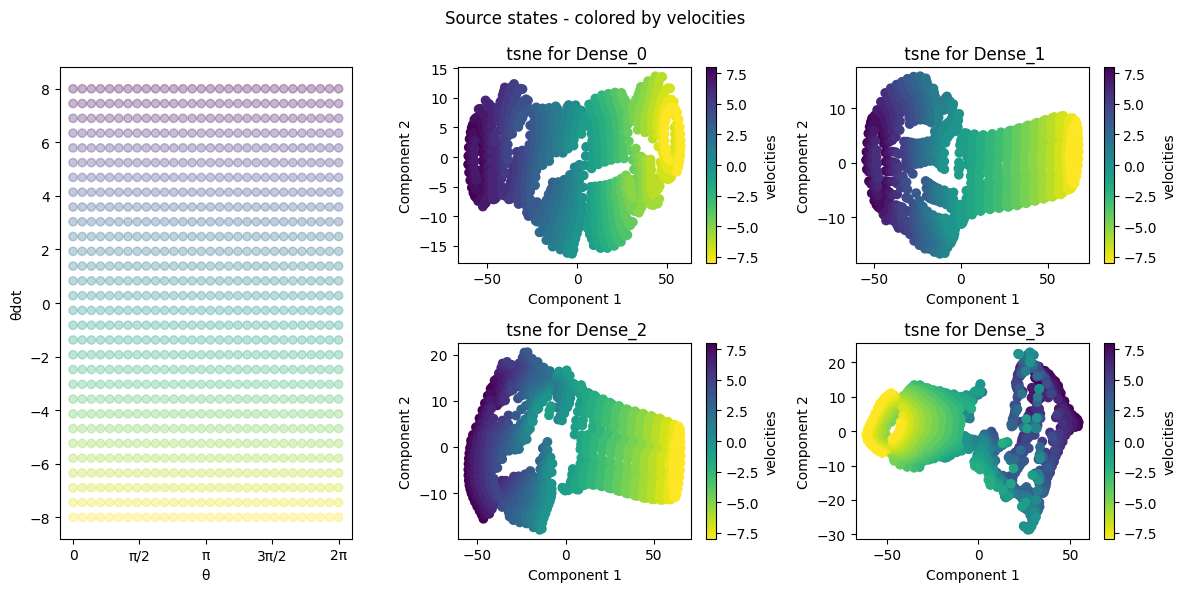

In [50]:
from matplotlib import gridspec
reversed_map = plt.cm.get_cmap('viridis').reversed() 

fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(thetas, velocities, alpha=0.3, c=velocities, cmap=reversed_map)  # Use the numbers as colors
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
ax.set_xlabel('θ')
ax.set_ylabel('θdot')
fig.suptitle('Source states - colored by velocities')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=velocities, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='velocities')

plt.tight_layout()
plt.show()

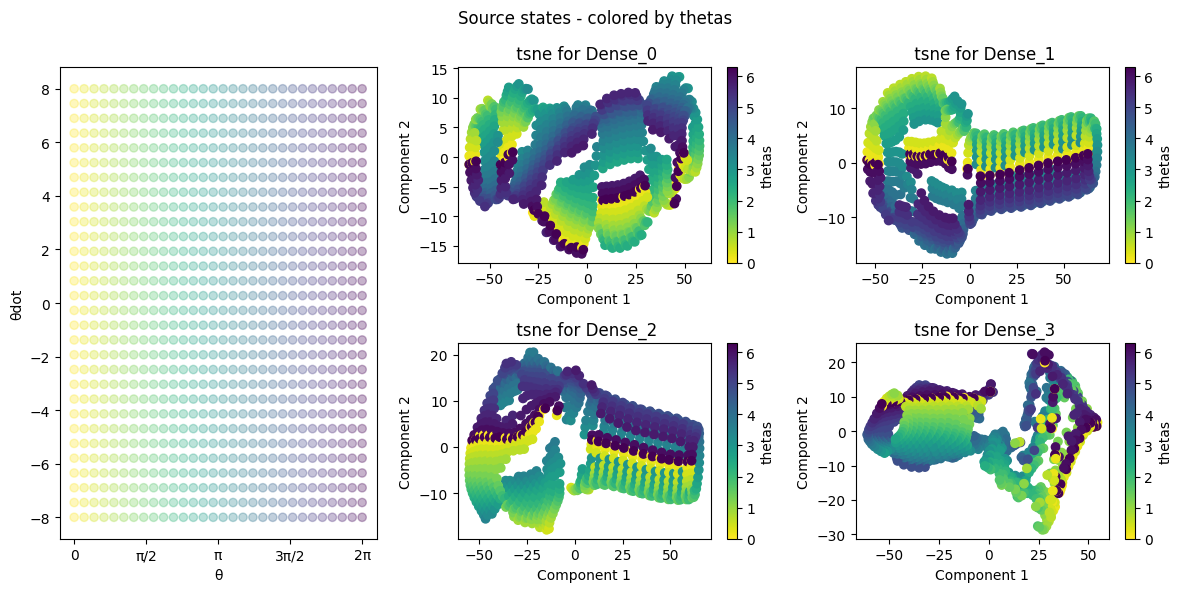

In [51]:
# 2 component t-SNE
fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(thetas, velocities, alpha=0.3, c=thetas, cmap=reversed_map)  # Use the numbers as colors
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
ax.set_xlabel('θ')
ax.set_ylabel('θdot')
fig.suptitle('Source states - colored by thetas')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=thetas, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='thetas')

plt.tight_layout()
plt.show()


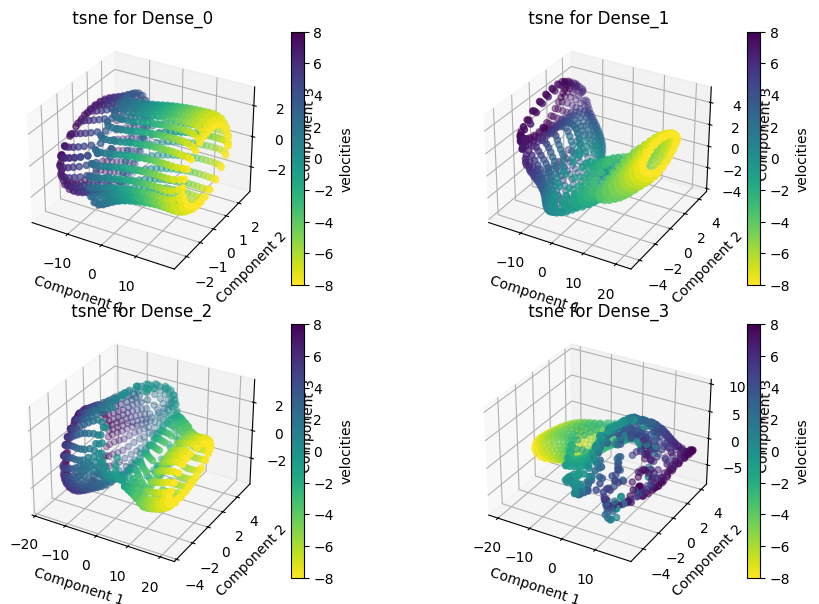

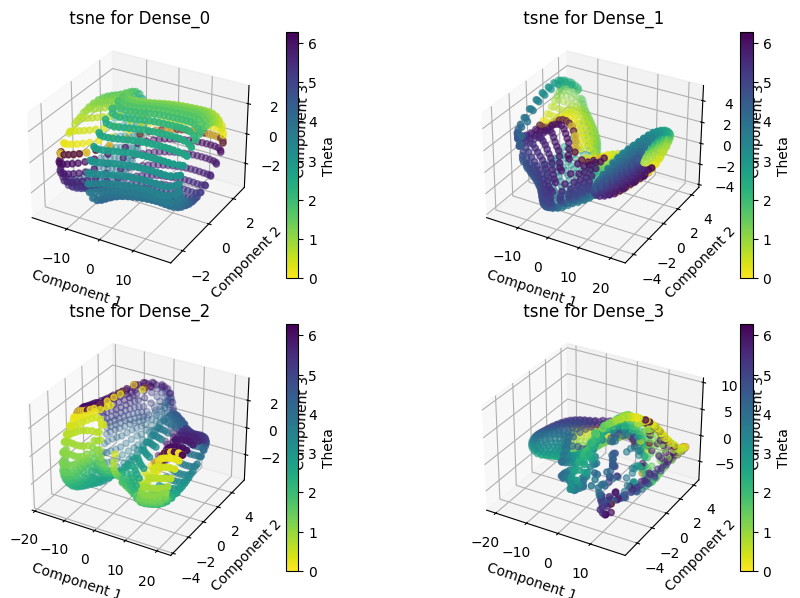

In [52]:
# 3 component tsne
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
tsne_3comp = {}
for layer in layer_names:
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    tsne = TSNE(n_components=3, random_state=0)
    projections = tsne.fit_transform(train_activations_layer)
    tsne_3comp[layer] = projections

# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')  # 2 rows, 2 columns
    scatter = ax.scatter(tsne_3comp[layer][:, 0], tsne_3comp[layer][:, 1], tsne_3comp[layer][:, 2],c=velocities, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    fig.colorbar(scatter, ax=ax, label='velocities')
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(10,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')  # 2 rows, 2 columns
    scatter = ax.scatter(tsne_3comp[layer][:, 0], tsne_3comp[layer][:, 1], tsne_3comp[layer][:, 2],c=thetas, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    fig.colorbar(scatter, ax=ax, label='Theta')
plt.tight_layout()
plt.show()

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 

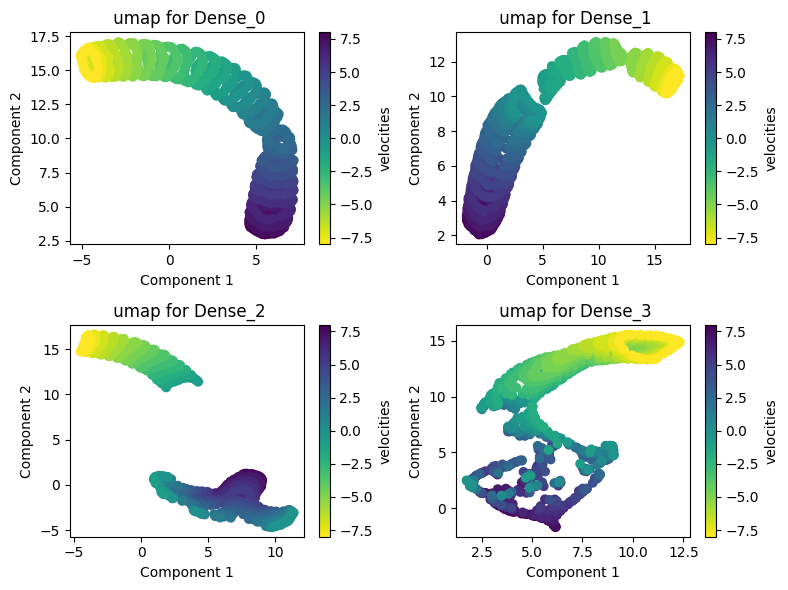

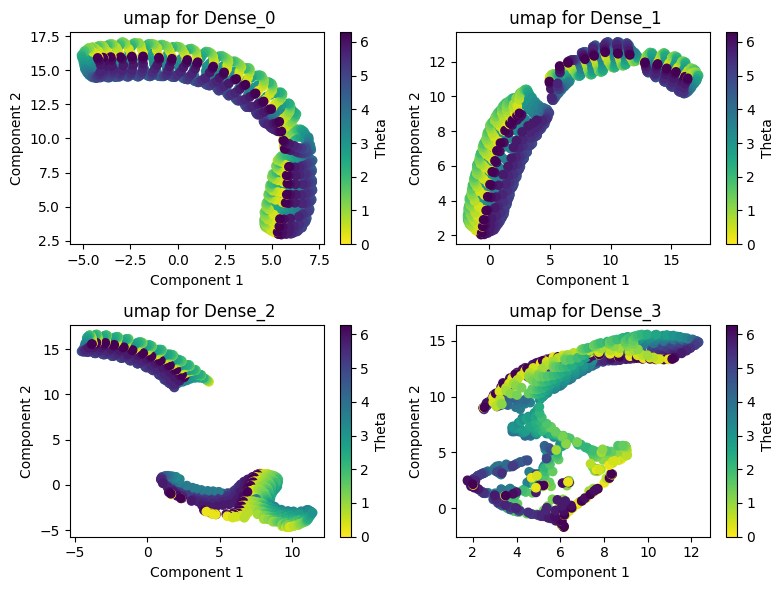

In [53]:
# UMAP 2D 
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
umap_all2d = {}
for layer in layer_names:
    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    umap_all2d[layer] = umap_2d.fit_transform(train_activations_layer)

fig = plt.figure(figsize=(8,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1) 
    scatter = ax.scatter(umap_all2d[layer][:, 0],umap_all2d[layer][:, 1], c = velocities, cmap = reversed_map)
    ax.set_title(f' umap for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    # axs[i].legend()
    fig.colorbar(scatter, ax=ax, label='velocities')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1) 
    scatter = ax.scatter(umap_all2d[layer][:, 0],umap_all2d[layer][:, 1], c = thetas, cmap = reversed_map)
    ax.set_title(f' umap for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    # axs[i].legend()
    fig.colorbar(scatter, ax=ax, label='Theta')
plt.tight_layout()

In [54]:
# # UMAP 3D
# layer_names = list(atom_activations_alllayers.keys())
# n_layers = len(layer_names)
# umap_all3d = {}
# for layer in layer_names: 
#     umap_3d = UMAP(n_components=3, init='random', random_state=0)
#     train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
#     umap_all3d[layer] = umap_3d.fit_transform(train_activations_layer)

# fig = plt.figure(figsize=(8,6))
# for i, layer in enumerate(layer_names):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     scatter = ax.scatter(umap_all3d[layer][:, 0], umap_all3d[layer][:, 1], umap_all3d[layer][:, 2],c=velocities, cmap=reversed_map)
#     ax.set_title(f' umap for {layer}')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     fig.colorbar(scatter, ax=ax, label='velocities')
# plt.tight_layout()
# plt.show()
# fig = plt.figure(figsize=(8,6))
# for i, layer in enumerate(layer_names):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     scatter = ax.scatter(umap_all3d[layer][:, 0], umap_all3d[layer][:, 1], umap_all3d[layer][:, 2],c=thetas, cmap=reversed_map)
#     ax.set_title(f' umap for {layer}')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     fig.colorbar(scatter, ax=ax, label='Theta')
# plt.tight_layout()
# plt.show()


In [55]:
# different sources, so no color basis - maybe generate for different latents and color same source? #TODO


### Effect of different latents 

In [56]:
atom_i = 7
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
layers = ['Dense_3']
activations_layers_randomz = []
for i in np.random.randint(0,100,size=5):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
    activations_layers_randomz.append(activations_layer)


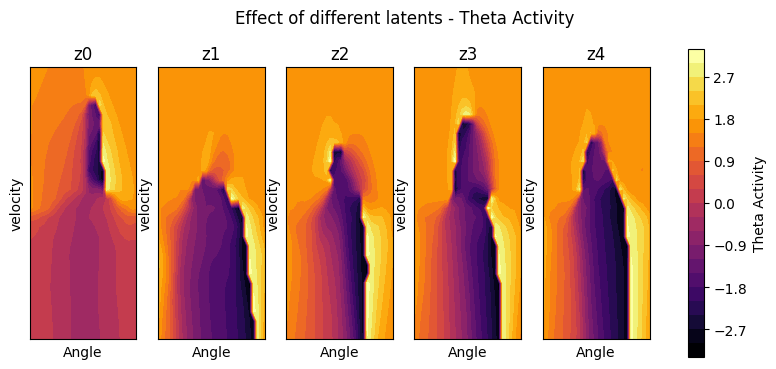

In [ ]:
# Plot with respect to theta arctan(neuron1 output, neuron2 output)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
n = len(activations_layers_randomz)
cols = 5 
rows = n // cols 
position = range(1,n + 1)
fig = plt.figure(figsize=(10,4))
global_min = -np.pi
global_max = np.pi
scatters = []
for k, activations_layer in enumerate(activations_layers_randomz): 
    ax = fig.add_subplot(rows, cols, position[k])
    theta = np.arctan2(activations_layer[:, 0], activations_layer[:, 1])
    activations_2d = theta.reshape(len(thetadot_all), len(theta_all))
    scatter = ax.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
    scatters.append(scatter)
    ax.set_aspect('equal')
    ax.set_title(f'z{k}')
    plt.xticks([]), plt.yticks([]) 
    ax.set_xlabel('Angle')
    ax.set_ylabel('velocity')
fig.colorbar(scatters[0], ax=fig.get_axes(), label='Theta Activity')
fig.suptitle('Effect of different latents - Theta Activity')
plt.show()

### Other Dense layers : Dense 0,1,2

#### Dense1

In [ ]:
importlib.reload(modelviz_pendulum_utils)

activations_layer.shape: (100, 32)


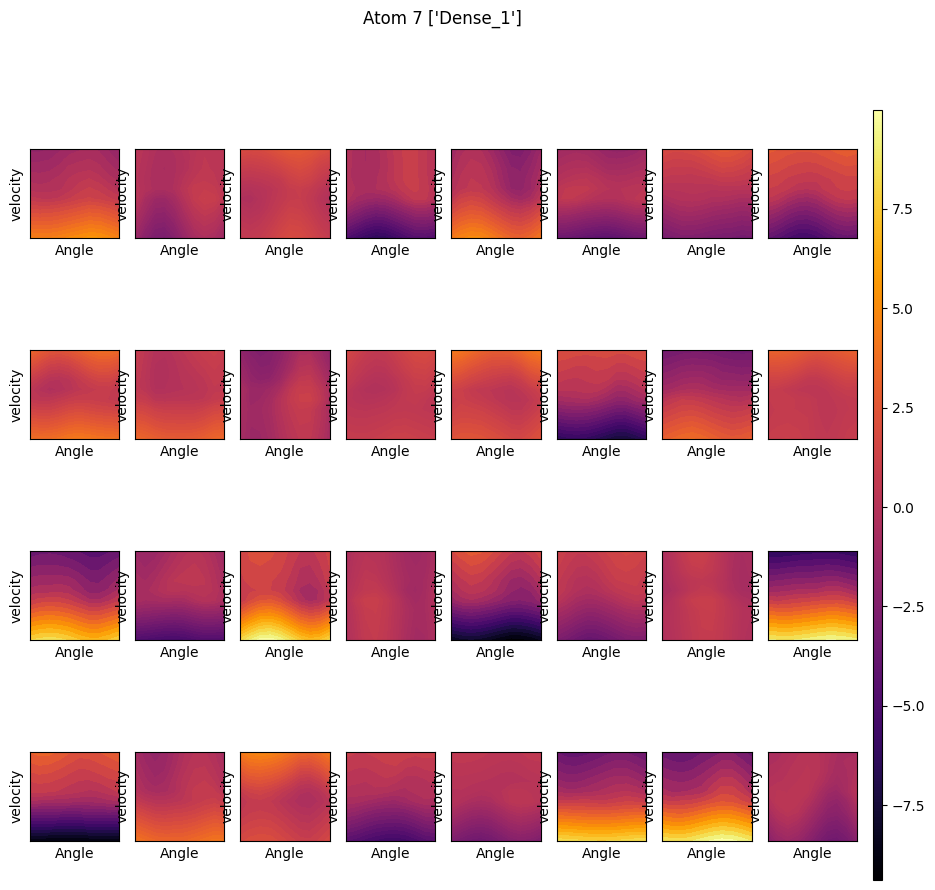

In [ ]:
atom_i = 7
layers = ['Dense_1']
latent_rng_seed = 0 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(0, activations_layer.shape[-1])
figlabel = f'Atom {atom_i} {layers}'
modelviz_pendulum_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel, theta_all, thetadot_all, normalize=False)

activations_layer.shape: (900, 32)


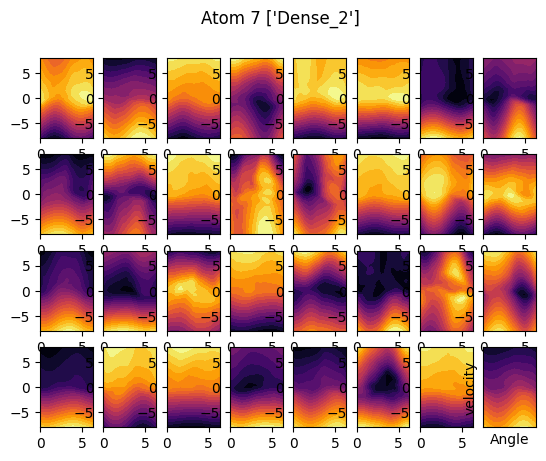

In [ ]:
atom_i = 7
layers = ['Dense_2']
latent_rng_seed = 0 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(0, activations_layer.shape[-1])
figlabel = f'Atom {atom_i} {layers}'
modelviz_pendulum_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel, theta_all, thetadot_all, normalize=False)

## 1 source state - different latents added  will generate different successor states
so 1 neuron - n_samples activations for different xs?

In [ ]:
import einops
def multiple_samples_compute_activation_layer_1source(atom_params, source_state, layers, num_samples):
    context = einops.repeat(source_state, "s -> i s", i=num_samples)
    zs = jax.random.normal(rng, (num_samples, num_latent_dims))
    xs_all = jnp.concatenate((zs, context), axis=-1)

    all_samples_activations= []
    for xs_atom in xs_all:
        preds, feats = modelviz_pendulum_utils.predict_layer(state.generator, atom_params, xs_atom,layers) 
        activations_layer= feats['intermediates'][layers[0]]['__call__'][0]
        all_samples_activations.append(activations_layer)
    all_samples_activations = np.array(all_samples_activations)

    return all_samples_activations

def show_allsamples_compute_activation_layer_all_sources(atom_params, sources_all, layers,num_samples):
    activations_all = []
    for source_state in sources_all:
        activations_all.append(multiple_samples_compute_activation_layer_1source(atom_params, source_state, layers,num_samples))
    return np.array(activations_all)

# def plot_neuron_activations_samples(activations_layer, neuron_idx,label):
#     # plot for single neuron
#     # plt for each source - several samples
#     fig = plt.figure()
#     Tot = activations_layer.shape[1]
#     Cols = 10
#     if Tot < Cols:
#         Cols = Tot
#     Rows = Tot // Cols 
#     if Tot % Cols != 0:
#         Rows += 1
#     Position = range(1,Tot + 1)
#     activations_neuron = activations_layer[:,:, neuron_idx]
#     # outputs_reshaped = activations_selected.reshape(X.shape)
#     for k in range(Tot):
#         activations_selected = activations_neuron[:, k]
#         ax = fig.add_subplot(Rows,Cols,Position[k])
#         activations_selected = activations_selected.reshape(len(thetadot_all), len(theta_all))
#         ax.contourf(theta_all, thetadot_all, activations_selected, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
#     plt.title(label)

In [ ]:
# from model_viz_functions_riab import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(state.generator, atom_params, source_states_env, layers,num_samples,num_latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)